In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import intake
import numpy as np
import xgcm
from xmitgcm import llcreader

In [3]:
import dask
import xesmf as xe

In [3]:
from dask.distributed import LocalCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster.scale(8)  # uses max of fig, but I think that is the default for locals
# cluster.adapt(minimum=10, maximum=20)  # gives up to the same capacity as server fig in cloud

client = Client(cluster)
cluster

In [4]:
model = llcreader.ECCOPortalLLC4320Model()
dm = model.get_dataset(varnames=['Eta', 'U', 'V', 'Theta', 'Salt'], k_levels=range(0, 90),
                       k_chunksize=10, iter_start=273024,
                       iter_stop=587520, read_grid=True, type='latlon')  # getting surface, 3 months at hrly
# dm = model.get_dataset(varnames=['Eta', 'U', 'V', 'Theta', 'Salt'], k_levels=[0,],
#                        iter_start=273024, iter_stop=587520, read_grid=True, type='latlon')  # getting surface, 3 months at hrly
# dm = model.get_dataset(varnames=['Eta', 'U', 'V', 'Theta', 'Salt'], k_levels=[0,], iter_stop=1495152)  # getting z=45 m

# from face to full grid *not sure if before/after merge:
# dm = llcreader.llcmodel.faces_dataset_to_latlon(dm, metric_vector_pairs=[])

In [5]:
dm

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 2184)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-11-28 ... 2012-02-26T23:00:00
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    CS       (j, i) float32 dask.array<chunksize=(12960, 4320), meta=np.ndarray>
    SN       (j, i)

In [7]:
# dm = dm.isel(i=slice(1650, 2330), j=slice(3190, 3780), i_g=slice(1650, 2330), j_g=slice(3190, 3780),)
dm = dm.isel(i=slice(1650+165, 2330-115), j=slice(3190+190, 3780-145), i_g=slice(1650+165, 2330-115), j_g=slice(3190+190, 3780-145),)

In [8]:
print(dm.nbytes/1e9)
print(dm['U'].nbytes/1e9)

321.794938196

In [9]:
# dm = dm.isel(time=slice(0, -1, 24))
dm = dm.isel(time=slice(0, -1, 24*30))
# dm = dm.isel(time=0)

In [10]:
print(dm.nbytes/1e9)
print(dm['U'].nbytes/1e9)

0.707080756

In [12]:
from dask.diagnostics import ProgressBar

with dask.config.set(scheduler='single-threaded'):
    with ProgressBar():
        u = dm['U'].load()
#         u = dask.compute(dm['U'], retries=10)

[########################################] | 100% Completed | 12min 40.2s


ValueError: replacement data must match the Variable's shape

In [13]:
from dask.diagnostics import ProgressBar

print(dm.nbytes/1e9)

with dask.config.set(scheduler='single-threaded'):
    with ProgressBar():
        dsl = dm.load()
#         dsl = dask.compute(dm, retries=50)

0.265216732
[########################################] | 100% Completed | 48min 36.7s


ValueError: replacement data must match the Variable's shape

In [14]:
with dask.config.set(scheduler='single-threaded'):
    with ProgressBar():
#         u = dm['U'].load()
        u = dask.compute(dm['U'], retries=10)

[####################                    ] | 52% Completed |  3min 48.1s


ValueError: buffer size must be a multiple of element size

In [15]:
with dask.config.set(scheduler='single-threaded'):
    with ProgressBar():
#         dsl = dm.load()
        dsl = dask.compute(dm, retries=50)

[############################            ] | 71% Completed | 14min 16.4s


ValueError: buffer size must be a multiple of element size

CPU times: user 2.02 s, sys: 609 ms, total: 2.63 s
Wall time: 11.5 s


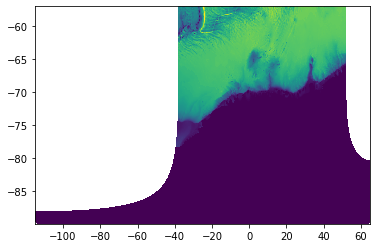

In [7]:
%%time
plt.figure()
plt.pcolormesh(dm['XC'].sel(face=0), dm['YC'].sel(face=0), dm['Depth'].sel(face=0))

CPU times: user 3.1 s, sys: 1.63 s, total: 4.73 s
Wall time: 20.4 s


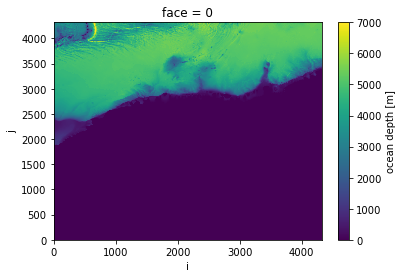

In [8]:
%%time
dm['Depth'].sel(face=0).plot()

In [9]:
model.get_dataset?

In [10]:
atime = dm['time'].values

In [30]:
1896 * 144
(1896 + 24*91) * 144

587520

In [28]:
atime[1896 + 24*91 -1]

numpy.datetime64('2012-02-29T23:00:00.000000000')

In [33]:
dm = dm.sel(face=0).isel(i=slice(1650, 2330), j=slice(3190, 3780), i_g=slice(1650, 2330), j_g=slice(3190, 3780),)

In [21]:
dm = dm.sel(time=slice('2011-12-01', '2012-02-29')).isel(time=slice(0, -1, 1))

In [6]:
dm

<xarray.Dataset>
Dimensions:  (face: 13, i: 400, i_g: 400, j: 255, j_g: 255, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 2184)
Coordinates:
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * j_g      (j_g) int64 3380 3381 3382 3383 3384 ... 3630 3631 3632 3633 3634
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 1815 1816 1817 1818 1819 ... 2210 2211 2212 2213 2214
  * time     (time) datetime64[ns] 2011-11-28 ... 2012-02-26T23:00:00
  * i        (i) int64 1815 1816 1817 1818 1819 ... 2210 2211 2212 2213 2214
  * j        (j) int64 3380 3381 3382 3383 3384 ... 3630 3631 3632 3633 3634
    CS       (j, i) float32 dask.array<chunksize=(255, 400), meta=np.ndarray>
    SN       (j, i) float32 da

In [7]:
dm.nbytes / 1e9

321.794938196

In [8]:
dm['U'].isel(time=slice(0, -1, 24)).nbytes / 1e9

3.34152

In [1]:
dm['V'].nbytes / 1e9

NameError: name 'dm' is not defined

In [32]:
with dask.config.set(scheduler='single-threaded'):
    with ProgressBar():
        v = dm['V'].load()
#         v = dask.compute(dm['V'], retries=50)

[########################################] | 100% Completed |  6min 45.6s


In [35]:
v.nbytes / 1e9

0.1460368

In [24]:
dm

<xarray.Dataset>
Dimensions:  (face: 13, i: 400, i_g: 400, j: 255, j_g: 255, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 91)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int64 3380 3381 3382 3383 3384 ... 3630 3631 3632 3633 3634
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * i_g      (i_g) int64 1815 1816 1817 1818 1819 ... 2210 2211 2212 2213 2214
  * j        (j) int64 3380 3381 3382 3383 3384 ... 3630 3631 3632 3633 3634
  * time     (time) datetime64[ns] 2011-11-28 2011-11-29 ... 2012-02-26
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 1815 1816 1817 1818 1819 ... 2210 2211 2212 2213 2214
    CS       (j, i) float32 dask.array<chunksize=(255, 400), meta=np.ndarray>
    SN       (j, i) float32 da

In [56]:
%%time
plt.figure()
plt.pcolormesh(dsl[0]['Salt'].isel(k=40))

ValueError: conflicting sizes for dimension 'k': length 18 on 'hFacC' and length 90 on 'k'

<Figure size 432x288 with 0 Axes>

In [58]:
dsl[0]['Salt'][0]

ValueError: conflicting sizes for dimension 'k': length 18 on 'hFacC' and length 90 on 'k'

In [16]:
%%time
plt.figure()
dm['Salt'].isel(time=10).plot()

IndexError: index 10 is out of bounds for axis 0 with size 1

<Figure size 432x288 with 0 Axes>

CPU times: user 753 ms, sys: 79 ms, total: 832 ms
Wall time: 11.9 s


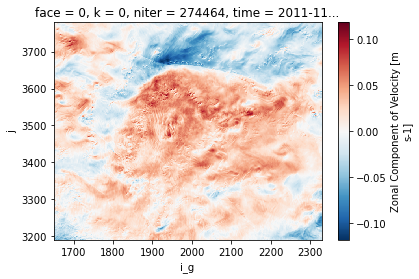

In [38]:
%%time
plt.figure()
dm['U'].isel(time=10).plot()

CPU times: user 3.08 s, sys: 1.41 s, total: 4.49 s
Wall time: 5.39 s


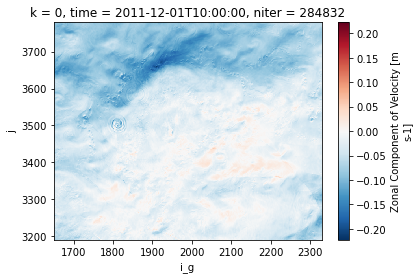

In [29]:
%%time
plt.figure()
dm['U'].isel(time=10).plot()

CPU times: user 6.06 s, sys: 2.22 s, total: 8.29 s
Wall time: 9.29 s


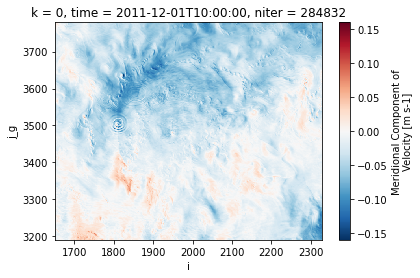

In [30]:
%%time
plt.figure()
dm['V'].isel(time=10).plot()

CPU times: user 741 ms, sys: 85.2 ms, total: 826 ms
Wall time: 12 s


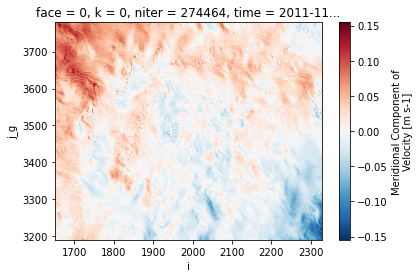

In [39]:
%%time
plt.figure()
dm['V'].isel(time=10).plot()

In [51]:
dm2 = model.get_dataset(varnames=['Eta', 'U', 'V', 'Theta', 'Salt'], k_levels=[0,], iter_start=273024,
                        iter_stop=587520, read_grid=True, )  # getting surface, 3 months at hrly
# dm2 = llcreader.llcmodel.faces_dataset_to_latlon(dm2)

In [47]:
dm2['time'].values[0]

numpy.datetime64('2011-11-28T00:00:00.000000000')

In [3]:
model.get_dataset?

Object `model.get_dataset` not found.


In [52]:
dm2 = dm2.isel(i=slice(1650, 2330), j=slice(3190, 3780), i_g=slice(1650, 2330), j_g=slice(3190, 3780),)

CPU times: user 3.23 s, sys: 332 ms, total: 3.56 s
Wall time: 38.3 s


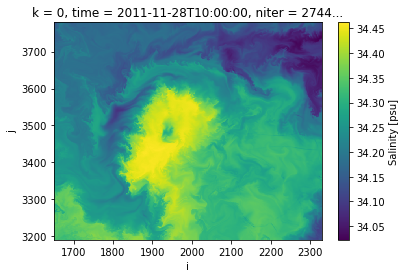

In [53]:
%%time
plt.figure()
dm2['Salt'].isel(time=10).plot()

In [56]:
%%time
plt.figure()
dm2['U'].mean(dim='time').plot()

AssertionError: 

<Figure size 432x288 with 0 Axes>

In [57]:
# from dask.diagnostics import ProgressBar
dm2 = dm2.isel(time=slice(0, -1, 24))
print(dm2.nbytes/1e9)
with dask.config.set(scheduler='single-threaded'):
    dml = dask.compute(dm2, retries=10)

0.765511568


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [59]:
%time vv = dm2['V'].load()

ValueError: buffer size must be a multiple of element size

In [32]:
dm['V'].nbytes / 1e9

3.5032784

In [89]:
dm['XC'].values[190:-145, 165:-115].min()

-0.17708333

In [54]:
%time v = dm['V'].isel(time=10).load()

CPU times: user 700 ms, sys: 74.9 ms, total: 775 ms
Wall time: 11 s


In [36]:
5.38 * 24 * 90 / 3600

3.228

In [37]:
%time v = dm['V'].isel(time=slice(0, -1, 24)).load()

CPU times: user 4min 13s, sys: 3min 52s, total: 8min 5s
Wall time: 3min 15s


In [38]:
v.shape

(91, 1, 590, 680)

In [40]:
5.3 * 91 / 60

8.038333333333334

In [43]:
dm['V'].nbytes / 1e9

3.5032784

In [59]:
dm = dm.chunk({'time':37, 'i':-1, 'j':-1, 'i_g':-1, 'j_g':-1})

In [61]:
dm['V'].data

,Array,Chunk
Bytes,3.50 GB,59.38 MB
Shape,"(2183, 1, 590, 680)","(37, 1, 590, 680)"
Count,1922272 Tasks,59 Chunks
Type,float32,numpy.ndarray


In [66]:
%time v = dm['V'].isel(time=slice(0, -1, 24)).load()

ValueError: buffer size must be a multiple of element size

array([[[[-1.1954839e-02, -1.2515002e-02, -1.3517913e-02, ...,
          -8.7412678e-02, -8.3251894e-02, -7.9382569e-02],
         [-1.4717703e-02, -1.4381393e-02, -1.3776973e-02, ...,
          -8.5541427e-02, -8.2626335e-02, -8.1020422e-02],
         [-1.6816184e-02, -1.5324690e-02, -1.4904192e-02, ...,
          -8.4995404e-02, -8.4808424e-02, -8.4710911e-02],
         ...,
         [-8.0848020e-03,  5.0042300e-03,  8.1931241e-03, ...,
          -3.7416540e-02, -3.6749110e-02, -3.6130328e-02],
         [-9.0982923e-03,  3.2917080e-03,  7.0430073e-03, ...,
          -3.7594229e-02, -3.7247468e-02, -3.6673874e-02],
         [-9.6777687e-03, -9.3467381e-05,  5.8787214e-03, ...,
          -3.7296183e-02, -3.7443951e-02, -3.7244290e-02]]],


       [[[-2.0029077e-02, -2.4385540e-02, -2.5401715e-02, ...,
          -7.1474597e-02, -7.0039354e-02, -7.3784091e-02],
         [-1.5699096e-02, -2.0115240e-02, -2.2497371e-02, ...,
          -7.2381757e-02, -7.3538288e-02, -7.7799760e-02],
      

In [57]:
2183 / 37

59.0

In [63]:
dm

<xarray.Dataset>
Dimensions:  (face: 13, i: 680, i_g: 680, j: 590, j_g: 590, k: 1, k_l: 1, k_p1: 1, k_u: 1, time: 2183)
Coordinates:
  * k_u      (k_u) int64 0
  * k_p1     (k_p1) int64 0
  * j_g      (j_g) int64 3190 3191 3192 3193 3194 ... 3775 3776 3777 3778 3779
  * k_l      (k_l) int64 0
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 1650 1651 1652 1653 1654 ... 2325 2326 2327 2328 2329
  * i        (i) int64 1650 1651 1652 1653 1654 ... 2325 2326 2327 2328 2329
  * j        (j) int64 3190 3191 3192 3193 3194 ... 3775 3776 3777 3778 3779
  * k        (k) int64 0
  * time     (time) datetime64[ns] 2011-12-01 ... 2012-02-29T22:00:00
    niter    (time) int64 dask.array<chunksize=(37,), meta=np.ndarray>
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(37, 590, 680), meta=np.ndarray>
    Theta    (time, k, j, i) float32 dask.array<chunksize=(37, 1, 590, 680), meta=np.ndarray>
    Salt     (time, k, j, i) float32 dask.array<chunks